# Feature Extraction for PA vs. AP Chest X-ray View Classification

In [1]:
from functools import partial
from collections import defaultdict
import pydicom
import os
import glob
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

np.warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('../input/stage_2_train_labels.csv')
details = pd.read_csv('../input/stage_2_detailed_class_info.csv')
# duplicates in details just have the same class so can be safely dropped
details = details.drop_duplicates('patientId').reset_index(drop=True)
labels_w_class = labels.merge(details, how='inner', on='patientId')

In [3]:
# get lists of all train/test dicom filepaths
train_dcm_fps = glob.glob('../input/stage_2_train_images/*.dcm')
test_dcm_fps = glob.glob('../input/stage_2_test_images/*.dcm')

# read each file into a list (using stop_before_pixels to avoid reading the image for speed and memory savings)
train_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
test_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [4]:
def parse_dcm_metadata(dcm):
    unpacked_data = {}
    group_elem_to_keywords = {}
    # iterating here to force conversion from lazy RawDataElement to DataElement
    for d in dcm:
        pass
    # keys are pydicom.tag.BaseTag, values are pydicom.dataelem.DataElement
    for tag, elem in dcm.items():
        tag_group = tag.group
        tag_elem = tag.elem
        keyword = elem.keyword
        group_elem_to_keywords[(tag_group, tag_elem)] = keyword
        value = elem.value
        unpacked_data[keyword] = value
    return unpacked_data, group_elem_to_keywords

train_meta_dicts, tag_to_keyword_train = zip(*[parse_dcm_metadata(x) for x in train_dcms])
test_meta_dicts, tag_to_keyword_test = zip(*[parse_dcm_metadata(x) for x in test_dcms])

In [5]:
# join all the dicts
unified_tag_to_key_train = {k:v for dict_ in tag_to_keyword_train for k,v in dict_.items()}
unified_tag_to_key_test = {k:v for dict_ in tag_to_keyword_test for k,v in dict_.items()}

# quick check to make sure there are no different keys between test/train
assert len(set(unified_tag_to_key_test.keys()).symmetric_difference(set(unified_tag_to_key_train.keys()))) == 0

tag_to_key = {**unified_tag_to_key_test, **unified_tag_to_key_train}
tag_to_key

{(8, 5): 'SpecificCharacterSet',
 (8, 22): 'SOPClassUID',
 (8, 24): 'SOPInstanceUID',
 (8, 32): 'StudyDate',
 (8, 48): 'StudyTime',
 (8, 80): 'AccessionNumber',
 (8, 96): 'Modality',
 (8, 100): 'ConversionType',
 (8, 144): 'ReferringPhysicianName',
 (8, 4158): 'SeriesDescription',
 (16, 16): 'PatientName',
 (16, 32): 'PatientID',
 (16, 48): 'PatientBirthDate',
 (16, 64): 'PatientSex',
 (16, 4112): 'PatientAge',
 (24, 21): 'BodyPartExamined',
 (24, 20737): 'ViewPosition',
 (32, 13): 'StudyInstanceUID',
 (32, 14): 'SeriesInstanceUID',
 (32, 16): 'StudyID',
 (32, 17): 'SeriesNumber',
 (32, 19): 'InstanceNumber',
 (32, 32): 'PatientOrientation',
 (40, 2): 'SamplesPerPixel',
 (40, 4): 'PhotometricInterpretation',
 (40, 16): 'Rows',
 (40, 17): 'Columns',
 (40, 48): 'PixelSpacing',
 (40, 256): 'BitsAllocated',
 (40, 257): 'BitsStored',
 (40, 258): 'HighBit',
 (40, 259): 'PixelRepresentation',
 (40, 8464): 'LossyImageCompression',
 (40, 8468): 'LossyImageCompressionMethod'}

In [6]:
# using from_records here since some values in the dicts will be iterables and some are constants
train_df = pd.DataFrame.from_records(data=train_meta_dicts)
test_df = pd.DataFrame.from_records(data=test_meta_dicts)
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
#df = pd.concat([train_df, test_df])
df = train_df

In [7]:
df['PatientID'].head()

0    4ba3e640-eb0a-4f4f-900c-af7405bc1790
1    48ce306f-3dac-485f-a2bf-02865af43ff2
2    6d606539-4b71-43c7-b12b-bc16512da2fb
3    31ba8a38-bc46-4208-9225-f4a6290d7966
4    9f888f62-3d5b-49c5-aee2-e301c2f9604d
Name: PatientID, dtype: object

In [8]:
pa_ids = df[df['ViewPosition']=='PA']['PatientID'].sample(12000).tolist()

In [9]:
pa_ids

['b86e639a-5938-4126-b4fd-fc62f89ae7cf',
 '1d9dde4e-97cc-4163-a3d5-8b845ad60ded',
 '69c648f7-ef97-4c82-9587-4e0af5a0d44a',
 '5f7a6f70-a734-47d6-97a3-aa7ede0a2af8',
 '8e45c607-73ea-4029-b9bc-adeec549b0dc',
 'ceb849b4-5618-4c3b-b34a-6ef007ae2ba0',
 '3dac7ad3-43fa-4b57-8990-84cbc11d454b',
 '393af041-d791-44c9-9126-17c47bb099a2',
 'e3fab001-eee9-4edc-b6be-9a60c912e2e5',
 '00eeb3c9-a892-4fac-a67a-aaa6cc7ffd5c',
 'c984e858-ac0e-46ec-9620-9efa57c08976',
 '858f0e6c-fb62-456e-9543-fc0cb512e059',
 'da9bfdb4-a34a-4014-a4a3-b2687aef0166',
 'a1214924-2cc5-481d-b329-bdacded69ff8',
 '4b59157a-5edb-46eb-97b5-4aac3be1dc1e',
 '606aba72-d0db-42d5-97e8-c40d88673dcf',
 'd1d3122f-9567-4c5d-a7e8-d8c00f8e00ae',
 'c210eab7-72f4-4d5a-94b2-7550ff5acf0f',
 '953fa799-1ba9-4e45-b4b1-2c1c39966412',
 '121ae1f2-0e8e-43f3-8dfc-93ffc2cfff22',
 'db9ffc16-5076-4f41-8693-dd1d54a9daaf',
 '97018841-5669-4870-9bdd-343e76156fab',
 'f7efd4bc-b7b8-4da0-bd04-291c912e98e8',
 '9c472be2-35ca-4ff5-9c2b-2f2743aa1d0b',
 'a75649b5-f044-

In [10]:
ap_ids = df[df['ViewPosition']=='AP']['PatientID'].sample(12000).tolist()

In [11]:
len(ap_ids)

12000

In [12]:
import skimage.measure
from scipy.signal import find_peaks, peak_prominences
import cv2
import math
from skimage.feature import hog
from skimage import data, exposure

def extract_feature(file, view):
    dcm_file = '../input/stage_2_train_images/'+file+'.dcm'
    dcm_data = pydicom.read_file(dcm_file)
    img = dcm_data.pixel_array
    pool = skimage.measure.block_reduce(img, (16,16), np.mean)
    filt = cv2.GaussianBlur(pool,(5,5),0)
    vip = np.mean(filt,axis=0)
    hip = np.mean(filt,axis=1)
    x = np.reshape(vip,(1,64))
    y = np.reshape(hip,(1,64))
    fd, hog_image = hog(filt, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=False)

    final_feat = np.reshape(np.append(x,y),(1,128))
    hogfeat = np.reshape(fd,(1,128))
    final_feat = np.reshape(np.append(final_feat,hogfeat),(1,256))
    feat_df = pd.DataFrame(final_feat)
    #print(feat_df.head())
    
    feat1 = np.array(feat_df.iloc[0,2:62])
    peaks = find_peaks(feat1)[0]
    
    
    
    if peaks.shape[0]<1:
        feat_df['p1'] = 16
    else:    
        feat_df['p1'] = peaks[0] #f1

    if peaks.shape[0]<2:
        feat_df['p2'] = 32
    else:    
        feat_df['p2'] = peaks[1] #f2

    if peaks.shape[0] < 3: 
        feat_df['p3'] = (64-feat_df['p2'])//2
    else:    
        feat_df['p3'] = peaks[2] #f3 
    
    feat_df['ph1'] = feat1[feat_df['p1']] #f4
    feat_df['ph2'] = feat1[feat_df['p2']] #f5
    feat_df['ph3'] = feat1[feat_df['p3']] #f6
    
    feat_df['pdx12'] = math.fabs(feat_df['p1'][0] - feat_df['p2'][0]) #f7
    feat_df['pdx23'] = math.fabs(feat_df['p2'][0] - feat_df['p3'][0]) #f8
    feat_df['pdx31'] = math.fabs(feat_df['p3'][0] - feat_df['p1'][0]) #f9
    feat_df['hdy12'] = math.fabs(feat_df['ph1'][0] - feat_df['ph2'][0]) #f10
    feat_df['hdy23'] = math.fabs(feat_df['ph2'][0] - feat_df['ph3'][0]) #f11
    feat_df['hdy_avg'] = math.fabs(feat_df['ph2'][0] - (feat_df['ph1'][0]+feat_df['ph3'][0])/2.0 ) #f12

    notch = find_peaks(-feat1)[0]

    if notch.shape[0]<1:
        feat_df['n1'] = (feat_df['p1'] + feat_df['p2'])//2
    else:    
        feat_df['n1'] = notch[0] #f13

    if notch.shape[0]<2:
        feat_df['n2'] = 59 - feat_df['n1']
    else:    
        feat_df['n2'] = notch[1] #f14

    feat_df['nh1'] = feat1[feat_df['n1']] #f15
    feat_df['nh2'] = feat1[feat_df['n2']] #f16
    feat_df['ndx'] = math.fabs(feat_df['n1'][0] - feat_df['n2'][0]) #f17
    feat_df['ndy'] = math.fabs(feat_df['nh1'][0] - feat_df['nh2'][0]) #f18 
    feat_df['n1_p1_dx'] = math.fabs(feat_df['p1'][0] - feat_df['n1'][0]) #f19
    feat_df['n1_p2_dx'] = math.fabs(feat_df['p2'][0] - feat_df['n1'][0]) #f20
    feat_df['n1_p3_dx'] = math.fabs(feat_df['p3'][0] - feat_df['n1'][0]) #f21
    feat_df['n2_p1_dx'] = math.fabs(feat_df['p1'][0] - feat_df['n2'][0]) #f22
    feat_df['n2_p2_dx'] = math.fabs(feat_df['p2'][0] - feat_df['n2'][0]) #f23
    feat_df['n2_p3_dx'] = math.fabs(feat_df['p3'][0] - feat_df['n2'][0]) #f24
    feat_df['n1_p1_dy'] = math.fabs(feat_df['ph1'][0] - feat_df['nh1'][0]) #f25
    feat_df['n1_p2_dy'] = math.fabs(feat_df['ph2'][0] - feat_df['nh1'][0]) #f26
    feat_df['n1_p3_dy'] = math.fabs(feat_df['ph3'][0] - feat_df['nh1'][0]) #f27
    feat_df['n2_p1_dy'] = math.fabs(feat_df['ph1'][0] - feat_df['nh2'][0]) #f28
    feat_df['n2_p2_dy'] = math.fabs(feat_df['ph2'][0] - feat_df['nh2'][0]) #f29
    feat_df['n2_p3_dy'] = math.fabs(feat_df['ph3'][0] - feat_df['nh2'][0]) #f30
    
    feat_df['patient_id'] = file
    if view == 'PA':
        feat_df['view'] = 0
    else:
        feat_df['view'] = 1
    return feat_df

In [13]:
test_df = extract_feature('bbac6ca1-30bd-4e32-8b3e-db0cae0c069a','PA')
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,248,249,250,251,252,253,254,255,p1,p2,p3,ph1,ph2,ph3,pdx12,pdx23,pdx31,hdy12,hdy23,hdy_avg,n1,n2,nh1,nh2,ndx,ndy,n1_p1_dx,n1_p2_dx,n1_p3_dx,n2_p1_dx,n2_p2_dx,n2_p3_dx,n1_p1_dy,n1_p2_dy,n1_p3_dy,n2_p1_dy,n2_p2_dy,n2_p3_dy,patient_id,view
0,136.641611,138.391444,143.734061,152.494522,162.992889,172.683994,180.49948,186.658392,191.052698,192.84394,190.95029,185.423611,178.12945,171.289823,166.149539,162.624485,159.644635,156.693068,154.667522,154.759657,157.063085,160.781156,165.501182,171.451417,178.88356,187.886763,197.751046,206.587027,213.279572,218.448791,222.022114,222.413057,219.027414,212.997174,205.506661,197.748895,191.308764,186.738083,183.219801,180.126292,...,0.598598,0.133072,0.01031,0.014694,0.038635,0.021257,0.004845,0.178587,7,29,49,192.84394,222.413057,202.197689,22.0,20.0,42.0,29.569117,20.215368,24.892243,16,39,154.667522,176.919414,23.0,22.251892,9.0,13.0,33.0,32.0,10.0,10.0,38.176418,67.745535,47.530167,15.924526,45.493643,25.278275,bbac6ca1-30bd-4e32-8b3e-db0cae0c069a,0


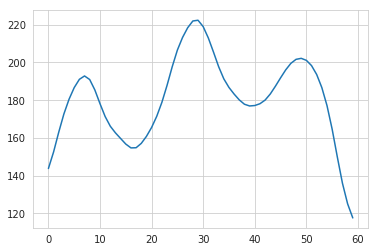

In [14]:
import matplotlib.pyplot as plt
feat_t = np.array(test_df.iloc[0,2:62])
plt.plot(feat_t)

In [15]:
pa_df = pd.DataFrame()
for i in pa_ids:
    df_feat = extract_feature(i,'PA')
    pa_df = pd.concat([pa_df,df_feat])

In [16]:
pa_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,248,249,250,251,252,253,254,255,p1,p2,p3,ph1,ph2,ph3,pdx12,pdx23,pdx31,hdy12,hdy23,hdy_avg,n1,n2,nh1,nh2,ndx,ndy,n1_p1_dx,n1_p2_dx,n1_p3_dx,n2_p1_dx,n2_p2_dx,n2_p3_dx,n1_p1_dy,n1_p2_dy,n1_p3_dy,n2_p1_dy,n2_p2_dy,n2_p3_dy,patient_id,view
0,83.364514,88.691611,99.674551,108.142294,111.510303,112.116464,112.156975,111.643103,110.220956,108.277960,106.285147,104.541005,103.221083,102.355977,101.965303,101.885943,101.704451,101.427117,101.687329,102.909458,104.769730,106.825804,109.253381,112.655773,117.559503,124.042363,131.223289,137.403548,141.420895,143.516630,144.709458,145.573940,145.080030,141.231187,134.083565,126.483074,120.876242,117.407616,114.895444,112.227287,...,0.698839,0.002330,0.003512,0.002606,0.013950,0.127902,0.046652,0.104209,4,29,52,112.156975,145.573940,119.162594,25.0,23.0,48.0,33.416965,26.411346,29.914156,15,41,101.427117,103.304508,26.0,1.877391,11.0,14.0,37.0,37.0,12.0,11.0,10.729858,44.146823,17.735476,8.852467,42.269432,15.858085,b86e639a-5938-4126-b4fd-fc62f89ae7cf,0
0,116.099841,100.734521,74.487440,63.164857,67.267274,78.633354,93.514810,109.053207,121.531491,129.179100,133.317459,135.443665,135.811523,134.636405,132.685033,130.694706,128.732792,126.607003,124.355691,122.024592,119.943848,118.923449,119.497280,121.694779,125.384371,130.105061,135.571193,142.142687,149.714635,157.752900,166.005493,173.176776,177.646217,180.149983,182.142861,182.836945,180.106316,172.762499,161.933353,151.015373,...,0.518015,0.032539,0.000000,0.000000,0.004483,0.008771,0.118233,0.317959,10,33,52,135.811523,182.836945,132.488022,23.0,19.0,42.0,47.025422,50.348924,48.687173,1,19,63.164857,118.923449,18.0,55.758592,9.0,32.0,51.0,9.0,14.0,33.0,72.646666,119.672088,69.323164,16.888074,63.913496,13.564573,1d9dde4e-97cc-4163-a3d5-8b845ad60ded,0
0,51.866124,46.734992,39.926392,39.810350,42.750497,45.333090,48.212085,52.633720,59.705697,70.626798,85.577442,101.044289,111.730217,116.257081,116.751318,114.524315,110.394351,105.996904,102.465436,100.044427,98.701070,98.170617,98.189511,98.750098,100.085480,102.692213,106.799775,112.088912,119.013878,128.992679,142.067287,155.633883,166.224856,173.207365,179.322042,185.464266,187.867996,182.223164,168.378954,150.937099,...,0.539176,0.027720,0.016707,0.000040,0.078964,0.107155,0.095554,0.134684,12,34,53,116.751318,187.867996,114.944664,22.0,19.0,41.0,71.116677,72.923331,72.020004,1,19,39.810350,98.170617,18.0,58.360267,11.0,33.0,52.0,7.0,15.0,34.0,76.940969,148.057646,75.134315,18.580702,89.697379,16.774048,69c648f7-ef97-4c82-9587-4e0af5a0d44a,0
0,157.648775,162.622195,172.241501,177.815981,175.938319,168.852436,161.051003,154.980788,150.386810,146.677431,143.725089,141.528411,140.052150,139.036365,138.072911,137.138913,136.814409,138.008415,141.503990,147.157918,153.799237,160.289151,166.264725,172.304536,179.503257,188.453712,198.753103,208.792096,216.151350,220.053453,222.326757,224.282825,224.856076,221.980160,214.492265,204.008161,194.067397,186.444763,180.373015,174.673601,...,0.413785,0.025405,0.009752,0.011663,0.039674,0.108544,0.114906,0.276269,1,30,54,177.815981,224.856076,175.055850,29.0,24.0,53.0,47.040095,49.800226,48.420161,14,44,136.814409,134.659333,30.0,2.155076,13.0,16.0,40.0,43.0,14.0,10.0,41.001572,88.041667,38.241440,43.156648,90.196743,40.396516,5f7a6f70-a734-47d6-97a3-aa7ede0a2af8,0
0,7.182789,20.179846,51.591769,84.306033,107.871429,123.845086,134.127578,138.222157,137.642134,134.949922,132.052116,130.075306,129.169552,128.922515,128.853970,128.322263,127.182215,126.311579,126.548208,128.052190,131.142315,136.054828,141.224768,144.529056,146.706960,150.507891,157.173303,165.704386,174.185187,180.824082,185.001977,187.645698,189.419973,189.554535,187.085994,181.628515,173.169565,162.502292,151.669674,142.574024,...,0.365707,0.004169,0.004544,0.006509,0.008083,0.226497,0.106451,0.278039,5,31,54,138.222157,189.554535,130.112118,26.0,23.0,49.0,51.33

In [17]:
ap_df = pd.DataFrame()
for i in ap_ids:
    df_feat = extract_feature(i,'AP')
    ap_df = pd.concat([ap_df,df_feat])

In [18]:
ap_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,248,249,250,251,252,253,254,255,p1,p2,p3,ph1,ph2,ph3,pdx12,pdx23,pdx31,hdy12,hdy23,hdy_avg,n1,n2,nh1,nh2,ndx,ndy,n1_p1_dx,n1_p2_dx,n1_p3_dx,n2_p1_dx,n2_p2_dx,n2_p3_dx,n1_p1_dy,n1_p2_dy,n1_p3_dy,n2_p1_dy,n2_p2_dy,n2_p3_dy,patient_id,view
0,51.606404,56.802934,69.221120,83.070949,94.710599,102.985913,108.240938,111.785602,114.736753,116.878711,117.574237,116.978766,115.578780,113.771788,111.767916,109.456269,107.028397,105.158986,104.388641,105.117527,107.895296,113.065290,119.765910,126.111424,131.170830,135.767905,141.023422,147.112479,153.493385,159.207149,163.062014,164.655401,164.731104,164.145819,163.075660,160.832157,156.459983,149.960974,142.032482,133.002856,...,0.436466,0.005606,0.009184,0.012906,0.061437,0.074246,0.184058,0.216097,8,30,54,117.574237,164.731104,104.373405,22.0,24.0,46.0,47.156867,60.357699,53.757283,16,45,104.388641,90.784243,29.0,13.604398,8.0,14.0,38.0,37.0,15.0,9.0,13.185596,60.342463,0.015236,26.789994,73.946861,13.589162,38929efc-a8ad-42b5-9fff-8ba881a7873e,1
0,33.732890,36.998631,46.550435,59.988935,73.042127,83.666050,92.568215,100.036293,105.254982,107.902740,108.622702,108.329312,107.655015,106.974966,106.569657,106.510403,106.714155,107.257318,108.332949,110.034236,112.512098,116.018016,120.313550,124.755569,129.405464,134.810460,140.694271,145.988845,149.741708,151.568769,151.811887,151.416875,151.096353,150.454909,148.653093,145.631015,141.772185,137.403837,133.143435,129.420332,...,0.311235,0.172172,0.036580,0.037221,0.038841,0.014704,0.064704,0.324542,8,28,46,108.622702,151.811887,108.275693,20.0,18.0,38.0,43.189185,43.536194,43.362689,13,44,106.510403,107.234046,31.0,0.723643,5.0,15.0,33.0,36.0,16.0,2.0,2.112299,45.301484,1.765290,1.388656,44.577841,1.041647,5951d644-7d41-4dd0-8166-0b4a27745cf3,1
0,62.491056,65.260819,68.726566,68.057771,65.699426,65.024278,67.119861,71.083847,75.150847,79.025142,82.910477,85.931582,87.412650,87.723792,87.645149,87.666523,87.729971,87.702437,87.899283,88.930491,91.273970,94.948223,99.462882,104.273565,109.273503,114.671843,120.497724,126.434014,132.092836,137.241765,141.711256,145.462832,148.696666,151.337328,152.745394,152.316227,149.931489,145.648383,139.550782,132.359769,...,0.074061,0.007938,0.010746,0.019046,0.043265,0.064304,0.456430,0.324210,11,14,32,87.723792,87.729971,152.745394,3.0,18.0,21.0,0.006179,65.015423,32.504622,3,12,65.024278,87.645149,9.0,22.620872,8.0,11.0,29.0,1.0,2.0,20.0,22.699514,22.705693,87.721117,0.078643,0.084821,65.100245,9f9b51c5-dd69-4bf8-bb3f-49def4d4b85f,1
0,159.619925,161.806152,166.070239,169.466552,171.765587,173.475865,174.669213,175.235921,175.043798,174.154096,172.777162,171.058992,169.035705,166.758949,164.365365,161.952001,159.469602,156.883387,154.388065,152.362612,151.204666,151.200591,152.238710,153.865428,155.911482,158.538706,161.797222,165.511093,169.270214,172.486908,174.525517,174.961986,173.799024,171.216273,167.323602,162.238558,156.439037,150.815062,145.836782,141.372358,...,0.542341,0.244686,0.016099,0.005696,0.064520,0.011832,0.019729,0.095096,5,29,52,175.235921,174.961986,146.899463,24.0,23.0,47.0,0.273935,28.062522,13.894293,19,42,151.200591,130.527900,23.0,20.672691,14.0,10.0,33.0,37.0,13.0,10.0,24.035330,23.761395,4.301128,44.708020,44.434085,16.371563,dba6433c-6c9b-4c58-b05e-637a4510ab22,1
0,74.211150,74.040879,74.632349,78.666796,87.864774,100.076255,111.274365,121.012730,132.421158,145.927811,156.844402,161.666023,162.420967,162.467580,162.783830,163.060363,163.130794,163.198944,163.904026,166.318531,170.838810,176.207659,180.981303,185.187099,189.681618,194.801234,199.846027,203.667709,205.754936,206.430424,206.172095,205.035408,202.651648,199.008276,195.036891,191.752429,189.202996,186.769053,183.973286,180.716235,...,0.456063,0.004143,0.000141,0.002327,0.028339,0.028019,0.176150,0.304819,27,32,16,206.430424,195.036891,163.904026,5.0,16.0,11.0,11.393533,31.132865,9.869666,29,30,

In [19]:
view_df = pd.concat([pa_df,ap_df])

In [20]:
view_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,248,249,250,251,252,253,254,255,p1,p2,p3,ph1,ph2,ph3,pdx12,pdx23,pdx31,hdy12,hdy23,hdy_avg,n1,n2,nh1,nh2,ndx,ndy,n1_p1_dx,n1_p2_dx,n1_p3_dx,n2_p1_dx,n2_p2_dx,n2_p3_dx,n1_p1_dy,n1_p2_dy,n1_p3_dy,n2_p1_dy,n2_p2_dy,n2_p3_dy,patient_id,view
0,83.364514,88.691611,99.674551,108.142294,111.510303,112.116464,112.156975,111.643103,110.220956,108.277960,106.285147,104.541005,103.221083,102.355977,101.965303,101.885943,101.704451,101.427117,101.687329,102.909458,104.769730,106.825804,109.253381,112.655773,117.559503,124.042363,131.223289,137.403548,141.420895,143.516630,144.709458,145.573940,145.080030,141.231187,134.083565,126.483074,120.876242,117.407616,114.895444,112.227287,...,0.698839,0.002330,0.003512,0.002606,0.013950,0.127902,0.046652,0.104209,4,29,52,112.156975,145.573940,119.162594,25.0,23.0,48.0,33.416965,26.411346,29.914156,15,41,101.427117,103.304508,26.0,1.877391,11.0,14.0,37.0,37.0,12.0,11.0,10.729858,44.146823,17.735476,8.852467,42.269432,15.858085,b86e639a-5938-4126-b4fd-fc62f89ae7cf,0
0,116.099841,100.734521,74.487440,63.164857,67.267274,78.633354,93.514810,109.053207,121.531491,129.179100,133.317459,135.443665,135.811523,134.636405,132.685033,130.694706,128.732792,126.607003,124.355691,122.024592,119.943848,118.923449,119.497280,121.694779,125.384371,130.105061,135.571193,142.142687,149.714635,157.752900,166.005493,173.176776,177.646217,180.149983,182.142861,182.836945,180.106316,172.762499,161.933353,151.015373,...,0.518015,0.032539,0.000000,0.000000,0.004483,0.008771,0.118233,0.317959,10,33,52,135.811523,182.836945,132.488022,23.0,19.0,42.0,47.025422,50.348924,48.687173,1,19,63.164857,118.923449,18.0,55.758592,9.0,32.0,51.0,9.0,14.0,33.0,72.646666,119.672088,69.323164,16.888074,63.913496,13.564573,1d9dde4e-97cc-4163-a3d5-8b845ad60ded,0
0,51.866124,46.734992,39.926392,39.810350,42.750497,45.333090,48.212085,52.633720,59.705697,70.626798,85.577442,101.044289,111.730217,116.257081,116.751318,114.524315,110.394351,105.996904,102.465436,100.044427,98.701070,98.170617,98.189511,98.750098,100.085480,102.692213,106.799775,112.088912,119.013878,128.992679,142.067287,155.633883,166.224856,173.207365,179.322042,185.464266,187.867996,182.223164,168.378954,150.937099,...,0.539176,0.027720,0.016707,0.000040,0.078964,0.107155,0.095554,0.134684,12,34,53,116.751318,187.867996,114.944664,22.0,19.0,41.0,71.116677,72.923331,72.020004,1,19,39.810350,98.170617,18.0,58.360267,11.0,33.0,52.0,7.0,15.0,34.0,76.940969,148.057646,75.134315,18.580702,89.697379,16.774048,69c648f7-ef97-4c82-9587-4e0af5a0d44a,0
0,157.648775,162.622195,172.241501,177.815981,175.938319,168.852436,161.051003,154.980788,150.386810,146.677431,143.725089,141.528411,140.052150,139.036365,138.072911,137.138913,136.814409,138.008415,141.503990,147.157918,153.799237,160.289151,166.264725,172.304536,179.503257,188.453712,198.753103,208.792096,216.151350,220.053453,222.326757,224.282825,224.856076,221.980160,214.492265,204.008161,194.067397,186.444763,180.373015,174.673601,...,0.413785,0.025405,0.009752,0.011663,0.039674,0.108544,0.114906,0.276269,1,30,54,177.815981,224.856076,175.055850,29.0,24.0,53.0,47.040095,49.800226,48.420161,14,44,136.814409,134.659333,30.0,2.155076,13.0,16.0,40.0,43.0,14.0,10.0,41.001572,88.041667,38.241440,43.156648,90.196743,40.396516,5f7a6f70-a734-47d6-97a3-aa7ede0a2af8,0
0,7.182789,20.179846,51.591769,84.306033,107.871429,123.845086,134.127578,138.222157,137.642134,134.949922,132.052116,130.075306,129.169552,128.922515,128.853970,128.322263,127.182215,126.311579,126.548208,128.052190,131.142315,136.054828,141.224768,144.529056,146.706960,150.507891,157.173303,165.704386,174.185187,180.824082,185.001977,187.645698,189.419973,189.554535,187.085994,181.628515,173.169565,162.502292,151.669674,142.574024,...,0.365707,0.004169,0.004544,0.006509,0.008083,0.226497,0.106451,0.278039,5,31,54,138.222157,189.554535,130.112118,26.0,23.0,49.0,51.33

In [21]:
view_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,248,249,250,251,252,253,254,255,p1,p2,p3,ph1,ph2,ph3,pdx12,pdx23,pdx31,hdy12,hdy23,hdy_avg,n1,n2,nh1,nh2,ndx,ndy,n1_p1_dx,n1_p2_dx,n1_p3_dx,n2_p1_dx,n2_p2_dx,n2_p3_dx,n1_p1_dy,n1_p2_dy,n1_p3_dy,n2_p1_dy,n2_p2_dy,n2_p3_dy,patient_id,view
0,51.558472,54.214648,63.281835,78.141893,93.864396,106.060972,114.266958,120.061501,124.601263,128.168764,130.849305,132.896969,134.437225,135.022242,133.948544,131.205914,127.525692,123.573025,119.709058,116.242018,113.455377,111.539989,110.590771,110.639385,111.738910,113.888321,117.065411,121.481115,127.055035,132.811490,137.676086,141.365741,144.095215,145.915980,146.479954,145.393241,142.744220,138.988335,134.603018,130.284210,...,0.034536,0.000461,0.004819,0.022808,0.149856,0.057711,0.348509,0.381298,11,32,52,135.022242,146.479954,135.754287,21.0,20.0,41.0,11.457712,10.725667,11.091689,20,43,110.590771,118.291273,23.0,7.700502,9.0,12.0,32.0,32.0,11.0,9.0,24.431471,35.889183,25.163516,16.730969,28.188681,17.463014,abe23a5c-46e0-4320-86d4-3655779e8559,1
0,67.124580,70.065619,79.112627,91.895917,103.582952,112.575348,120.162678,126.748656,131.483845,133.177848,131.833015,129.256606,127.016309,125.217408,123.537768,121.696524,119.546142,118.037193,118.696609,121.767721,126.381103,131.772746,137.581881,144.572217,154.057221,165.054195,174.618834,181.415671,185.945480,188.036541,186.904769,182.802285,176.481449,168.227110,159.073692,150.929590,144.547788,139.461435,135.538478,133.120182,...,0.155238,0.004028,0.000378,0.000000,0.008263,0.005501,0.108175,0.718416,7,27,47,133.177848,188.036541,140.475861,20.0,20.0,40.0,54.858692,47.560680,51.209686,15,38,118.037193,132.298847,23.0,14.261655,8.0,12.0,32.0,31.0,11.0,9.0,15.140656,69.999348,22.438668,0.879001,55.737693,8.177013,785afba9-c456-4c94-bfdd-7e613124cd67,1
0,150.829970,151.480129,151.509359,150.010461,149.285785,149.981224,150.905127,151.496444,151.771291,151.825971,151.767722,151.558907,150.998933,149.773686,147.658631,144.932903,142.246891,140.079853,138.597434,137.772519,137.566350,138.079032,139.278892,140.847354,142.693362,144.964394,147.413426,149.423765,150.419980,150.302747,149.676060,148.999073,147.925686,146.098775,143.726631,141.199888,138.798943,136.623255,134.669104,132.974478,...,0.161924,0.006243,0.001587,0.014525,0.077580,0.171260,0.460373,0.106505,7,26,46,151.825971,150.419980,136.816493,19.0,20.0,39.0,1.405992,13.603487,6.098748,2,18,149.285785,137.566350,16.0,11.719435,5.0,24.0,44.0,11.0,8.0,28.0,2.540186,1.134195,12.469293,14.259622,12.853630,0.749857,f8654099-285f-4d70-8ff1-9696afc932da,1
0,90.113968,93.825408,101.461120,108.360302,113.911150,118.719404,122.802741,126.210810,129.085168,131.403681,133.052059,134.078791,134.667594,134.899475,134.610415,133.628464,132.208367,130.914478,130.036140,129.481797,129.124144,128.931340,128.982693,129.466882,130.564853,132.315066,134.545017,137.027890,139.602582,142.052555,144.148164,145.889852,147.460093,148.835851,149.762299,150.121960,150.008029,149.554287,148.845106,147.858866,...,0.162810,0.014802,0.000000,0.000000,0.024667,0.005318,0.186240,0.606161,11,33,54,134.899475,150.121960,138.900097,22.0,21.0,43.0,15.222485,11.221863,13.222174,19,46,128.931340,137.423557,27.0,8.492217,8.0,14.0,35.0,35.0,13.0,8.0,5.968135,21.190620,9.968757,2.524082,12.698403,1.476540,c35f0f16-afd8-4d40-8f39-9b10a1d3ca72,1
0,87.215160,92.511416,103.203202,112.693871,120.582173,127.898675,134.387369,139.358611,142.170852,142.833464,141.972774,140.162308,138.023568,136.267476,134.752030,132.836403,130.846503,129.774864,130.099845,131.670660,134.044811,136.956769,140.722901,145.673756,151.391122,156.871245,161.383475,165.240088,169.162054,172.945286,175.656123,176.842439,176.816662,176.035241,174.700641,172.762208,170.050382,166.374213,161.758337,156.917907,...,0.638594,0.000000,0.000000,0.000000,0.010362,0.000000,0.010457,0.340586,7,29,51,142.833464,176.842439,132.968351,22.0,22.0,44.0,34.

In [22]:
view_df.to_csv('CXR_feature_IP_CXF24_HOG_24k.csv', index=False)